# Imports

In [1]:
import pickle
import random
import pathlib
import unicodedata

In [2]:
from itertools import groupby
from operator import itemgetter

In [3]:
import nltk
import numpy as np

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# PickledCorpusReader

In [5]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [6]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

In [7]:
from collections import Counter

corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words  = Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

77,930 vocabulary 1,624,862 word count


In [8]:
for category in corpus.categories():

    n_docs = len(corpus.fileids(categories=[category]))
    n_words = sum(1 for word in corpus.words(categories=[category]))

    print("- '{}' contains {:,} docs and {:,} words".format(category, n_docs, n_words))

- 'books' contains 71 docs and 41,438 words
- 'business' contains 389 docs and 222,182 words
- 'cinema' contains 100 docs and 69,153 words
- 'cooking' contains 30 docs and 37,854 words
- 'data_science' contains 41 docs and 31,354 words
- 'design' contains 55 docs and 18,260 words
- 'do_it_yourself' contains 122 docs and 28,050 words
- 'gaming' contains 128 docs and 70,778 words
- 'news' contains 1,159 docs and 850,688 words
- 'politics' contains 149 docs and 88,853 words
- 'sports' contains 118 docs and 68,884 words
- 'tech' contains 176 docs and 97,368 words


# Unsupervised Learning on Text

# Clustering by Document Similarity

## Distance Metrics

## Partitive Clustering

### k-means clustering

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.language = language
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token)
            and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        return [' '.join(self.normalize(doc)) for doc in documents]

In [11]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    """Transforms sparse to dense"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

In [12]:
class ListTransformer(BaseEstimator, TransformerMixin):
    """Transforms 2D array to list of 1D arrays"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return list(X)

In [13]:
from nltk.cluster import KMeansClusterer

class KMeansClusters(BaseEstimator):
    """sklearn wrapper for nltk.cluster.KMeansClusterer"""
    
    def __init__(self, k, distance, random_state=None):
        """
        k is the number of clusters
        model is the implementation of Kmeans
        """
        self.k = k
        self.distance = distance
        self.random_state = random_state
        self.model = KMeansClusterer(num_means=self.k,
                                     distance=self.distance,
                                     rng=random.Random(self.random_state),
                                     avoid_empty_clusters=True)
        
    def fit(self, documents, labels=None):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        self.model.cluster(documents)
        return self
    
    def predict(self, documents):
        """
        Predicts the closest cluster for each document in documents.
        """
        return list(map(self.model.classify, documents))
    
    def fit_predict(self, documents, labels=None):
        """Calls fit() and predict() methods"""
        return self.fit(documents).predict(documents)

In [14]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('list_transformer', ListTransformer()),
    ('clusters', KMeansClusters(k=7,
                                distance=nltk.cluster.util.cosine_distance,
                                random_state=42)),
])

In [15]:
documents = corpus.docs(categories=['news'])

In [16]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

CPU times: user 12.2 s, sys: 59 ms, total: 12.3 s
Wall time: 13.4 s


In [17]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [18]:
# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0))
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/56d63af0c1808113ffb88745.pickle
Cluster 2: news/56d7503fc18081081a6e1e15.pickle
Cluster 3: news/56d62570c1808113ffb87557.pickle
Cluster 4: news/56d75003c18081081a6e1b5e.pickle
Cluster 5: news/56d62554c1808113ffb87492.pickle
Cluster 6: news/56d64c7ac1808115036122b4.pickle
Cluster 7: news/56d6255dc1808113ffb874f0.pickle


### Optimizing k-means

In [19]:
from sklearn.cluster import MiniBatchKMeans

In [20]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('clusters', MiniBatchKMeans(n_clusters=7,
                                 random_state=42)),
])

In [21]:
documents = corpus.docs(categories=['news'])

In [22]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

CPU times: user 1.94 s, sys: 145 ms, total: 2.08 s
Wall time: 3.15 s


In [23]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [24]:
# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0))
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/5718011bc1808103a0d29d4d.pickle
Cluster 2: news/57107f2dc1808128a22e6f94.pickle
Cluster 3: news/57041c36c18081204db79348.pickle
Cluster 4: news/56d62554c1808113ffb87492.pickle
Cluster 5: news/56d7c01ec1808109e958eb2f.pickle
Cluster 6: news/57387db1c1808103a12a459a.pickle
Cluster 7: news/5710a362c1808128a22ec0e4.pickle


### Handling uneven geometries

## Hierarchical Clustering

### Agglomerative clustering

In [27]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

In [28]:
# ROOT = 'os.getcwd()'
# # small sample corpus of 40 news items for illustration purposes
# CORPUS = os.path.join(ROOT, "fixtures", "sample")

In [29]:
from nltk.corpus import wordnet as wn
from nltk.cluster import KMeansClusterer

In [30]:
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

In [31]:
def is_punct(token):
    # Is every character punctuation?
    return all(
        unicodedata.category(char).startswith('P')
        for char in token
    )

In [32]:
def wnpos(tag):
    # Return the WordNet POS tag from the Penn Treebank tag
    return {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

In [33]:
def normalize(document, stopwords=STOPWORDS):
    """
    Removes stopwords and punctuation, lowercases, lemmatizes
    """

    for token, tag in document:
        token = token.lower().strip()

        if is_punct(token) or (token in stopwords):
            continue

        yield lemmatizer.lemmatize(token, wnpos(tag))

In [34]:
class HierarchicalTopics(object):

    def __init__(self, corpus):
        """
        corpus is a corpus object, e.g. an HTMLCorpusReader()
        or an HTMLPickledCorpusReader() object
        """
        self.model = None
        self.vocab = list(
            set(normalize(corpus.words(categories=['news'])))
        )

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens using the segmentation and tokenization methods.

        One-hot encode the set of documents
        """
        features = set(normalize(document))
        return np.array([
            token in features for token in self.vocab], np.short)

    def cluster(self, corpus):
        """
        Fits the AgglomerativeClustering model to the given data.
        """
        self.model = AgglomerativeClustering()

        self.model.fit_predict([
            self.vectorize(
                corpus.words(fileid)) for fileid in
            corpus.fileids(categories=['news']
                           )
        ])

        self.labels = self.model.labels_
        self.children = self.model.children_

    def plot_dendrogram(self, **kwargs):
        # Distances between each pair of children
        distance = np.arange(self.children.shape[0])
        position = np.arange(self.children.shape[0])

        # Create linkage matrix and then plot the dendrogram
        linkage_matrix = np.column_stack([
            self.children, distance, position]
        ).astype(float)

        # Plot the corresponding dendrogram
        fig, ax = plt.subplots(figsize=(15, 7))  # set size
        ax = dendrogram(linkage_matrix, **kwargs)
        plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
        plt.tight_layout()
        plt.show()

In [36]:
from collections import Counter

corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())

labels = []
for fileid in corpus.fileids(categories=['news']):
    terms = []
    for term, count in Counter(list(normalize(corpus.words(fileid)))).most_common(10):
        terms.append(term)
    labels.append(terms)

In [38]:
clusterer = HierarchicalTopics(corpus)
clusterer.cluster(corpus)
# for idx, fileid in enumerate(corpus.fileids(categories=['news'])):
#     print(clusterer.labels[idx], fileid)

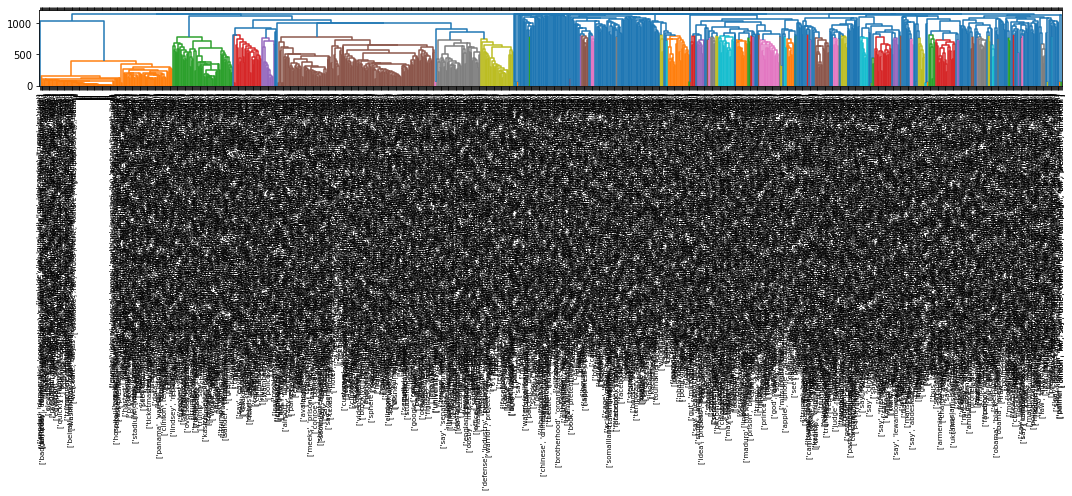

In [39]:
clusterer.plot_dendrogram(labels=labels, leaf_font_size=7)
# clusterer.plot_dendrogram(leaf_font_size=7)

# ALTERNATIVE

In [25]:
from sklearn.cluster import AgglomerativeClustering

In [32]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('clusters', AgglomerativeClustering()),
])

In [33]:
documents = corpus.docs(categories=['news'])

In [34]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

CPU times: user 8.26 s, sys: 190 ms, total: 8.45 s
Wall time: 9.56 s


# Modeling Document Topics

## Latent Dirichlet Allocation

### In Scikit-Learn

### The Gensim way

### Visualizing topics

## Latent Semantic Analysis

### In Scikit-Learn

### The Gensim way

## Non-Negative Matrix Factorization

### In Scikit-Learn